## Apply HOD and construct lightcone
This notebook pulls ltu-cmass snapshots, applies HOD models, and constructs an NGC-like lightcone

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib as mpl
mpl.style.use('./style.mcstyle')   # noqa
from matplotlib import pyplot as plt
import astropy
import pandas as pd
from astropy.io import fits
from tqdm import tqdm
import h5py

from astropy.cosmology import Planck18
cosmo = Planck18

In [2]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'

## Load observation catalog
In case you want to compute n(z) for yourself

In [6]:
# Load observations
from cmass.survey.tools import sky_to_xyz


def load_fits(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)
    return gals


zlim = 0.4, 0.7
fields = ['RA', 'DEC', 'Z', 'WEIGHT_SYSTOT', 'WEIGHT_NOZ', 'WEIGHT_CP']

# Load NGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_North.fits')
cmass = load_fits(fname, fields)
nrdz = cmass[['RA', 'DEC', 'Z']].values
mask = (nrdz[:, 2] > zlim[0]) & (nrdz[:, 2] < zlim[1])
nrdz = nrdz[mask]
nxyz = sky_to_xyz(nrdz, cosmo)

# Load SGC
fname = join(wdir, 'obs/galaxy_DR12v5_CMASS_South.fits')
cmass = load_fits(fname, fields)
srdz = cmass[['RA', 'DEC', 'Z']].values
mask = (srdz[:, 2] > zlim[0]) & (srdz[:, 2] < zlim[1])
srdz = srdz[mask]
sxyz = sky_to_xyz(srdz, cosmo)

print(len(nrdz), len(srdz))

579089 213205


[Text(0.5, 0, 'z'), Text(0, 0.5, 'N')]

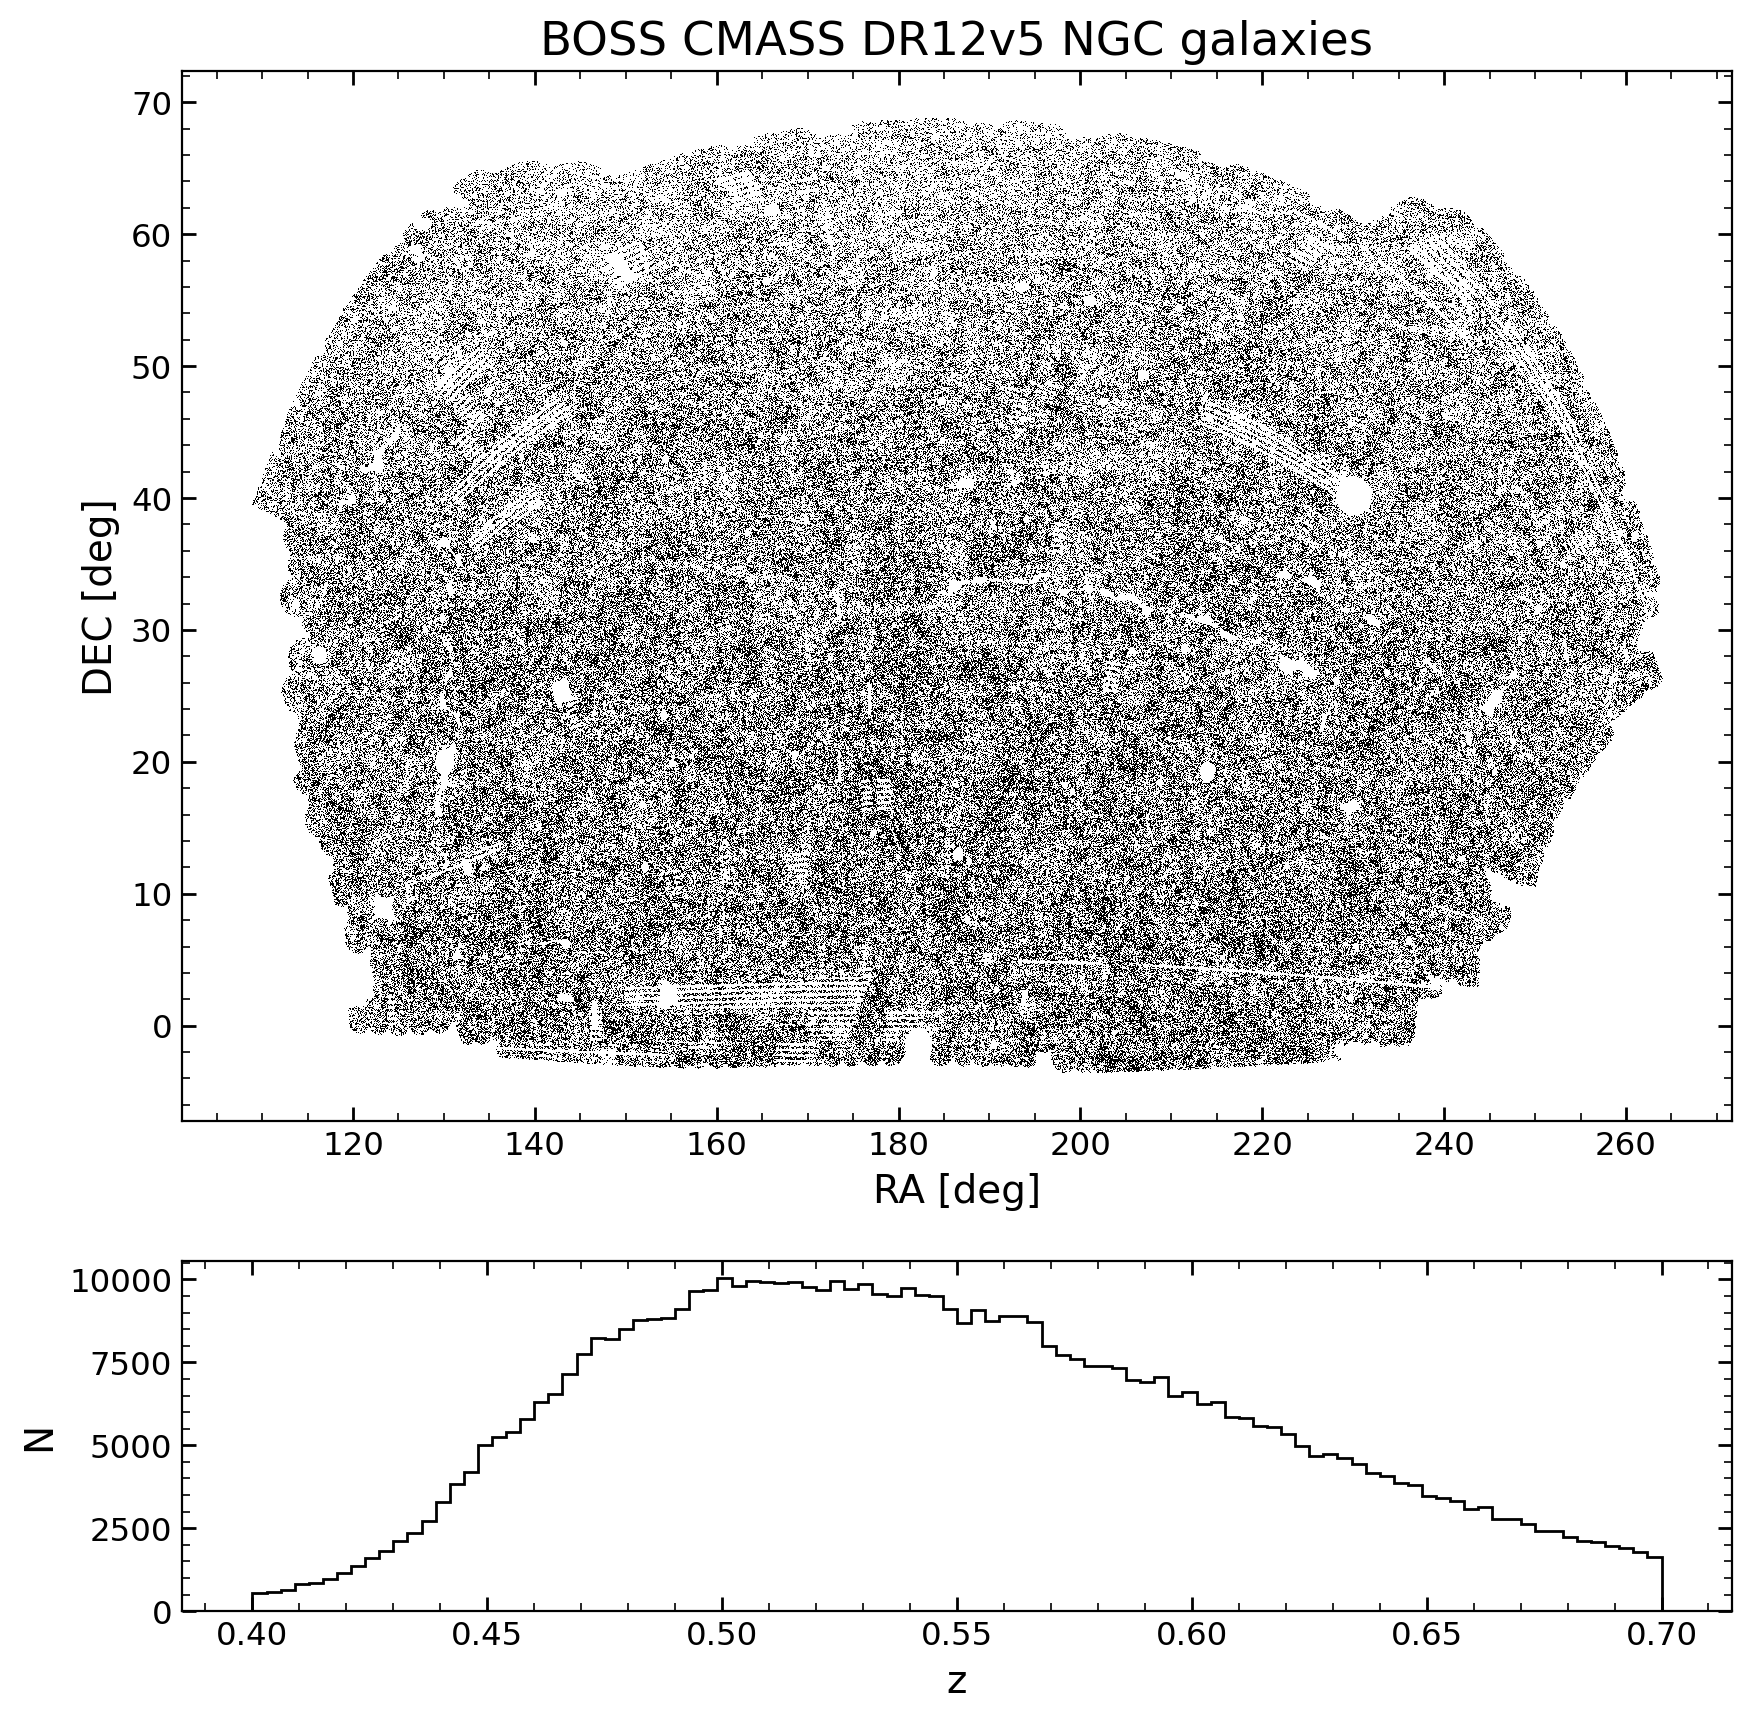

In [7]:
rdz = nrdz

f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw=dict(height_ratios=[3, 1]))

ax = axs[0]
ax.plot(rdz[:, 0], rdz[:, 1], 'k,', alpha=1)
ax.set(
    xlabel='RA [deg]',
    ylabel='DEC [deg]',
    title='BOSS CMASS DR12v5 NGC galaxies'
)

ax = axs[1]
ax.hist(rdz[:, 2], bins=100, histtype='step', color='k')
ax.set(
    xlabel='z',
    ylabel='N'
)

## Apply HOD and construct lightcone

In [3]:
from cmass.utils import cosmo_to_astropy
from omegaconf import OmegaConf

# Choose simulation
nbody = 'mtnglike'
sim = 'fastpm'
L, N = 3000, 384
lhid = 663  # close to fiducial

simpath = join(wdir, nbody, sim, f'L{L}-N{N}', f'{lhid}')

# Load configuration
config = OmegaConf.load(join(simpath, 'config.yaml'))
cosmo = config.nbody.cosmo
asave = config.nbody.asave
Nsnap = len(asave)
print(f'LHID={lhid}\ncosmo={cosmo}\nalist={asave}')

cosmo = cosmo_to_astropy(cosmo)

LHID=663
cosmo=[0.3223, 0.04625, 0.7015, 0.9607, 0.8311]
alist=[0.58622, 0.60633, 0.62644, 0.64655, 0.66666, 0.68677, 0.70688, 0.72699, 0.7471, 0.76721]


In [4]:
# Load halo snapshots
from cmass.bias.apply_hod import load_snapshot

hposs, hvels, hmasses, hmetas = [], [], [], []
for a in tqdm(asave):
    hpos, hvel, hmass, hmeta = load_snapshot(simpath, a)
    hposs.append(hpos), hvels.append(
        hvel), hmasses.append(hmass), hmetas.append(hmeta)

100%|██████████| 10/10 [00:02<00:00,  4.54it/s]


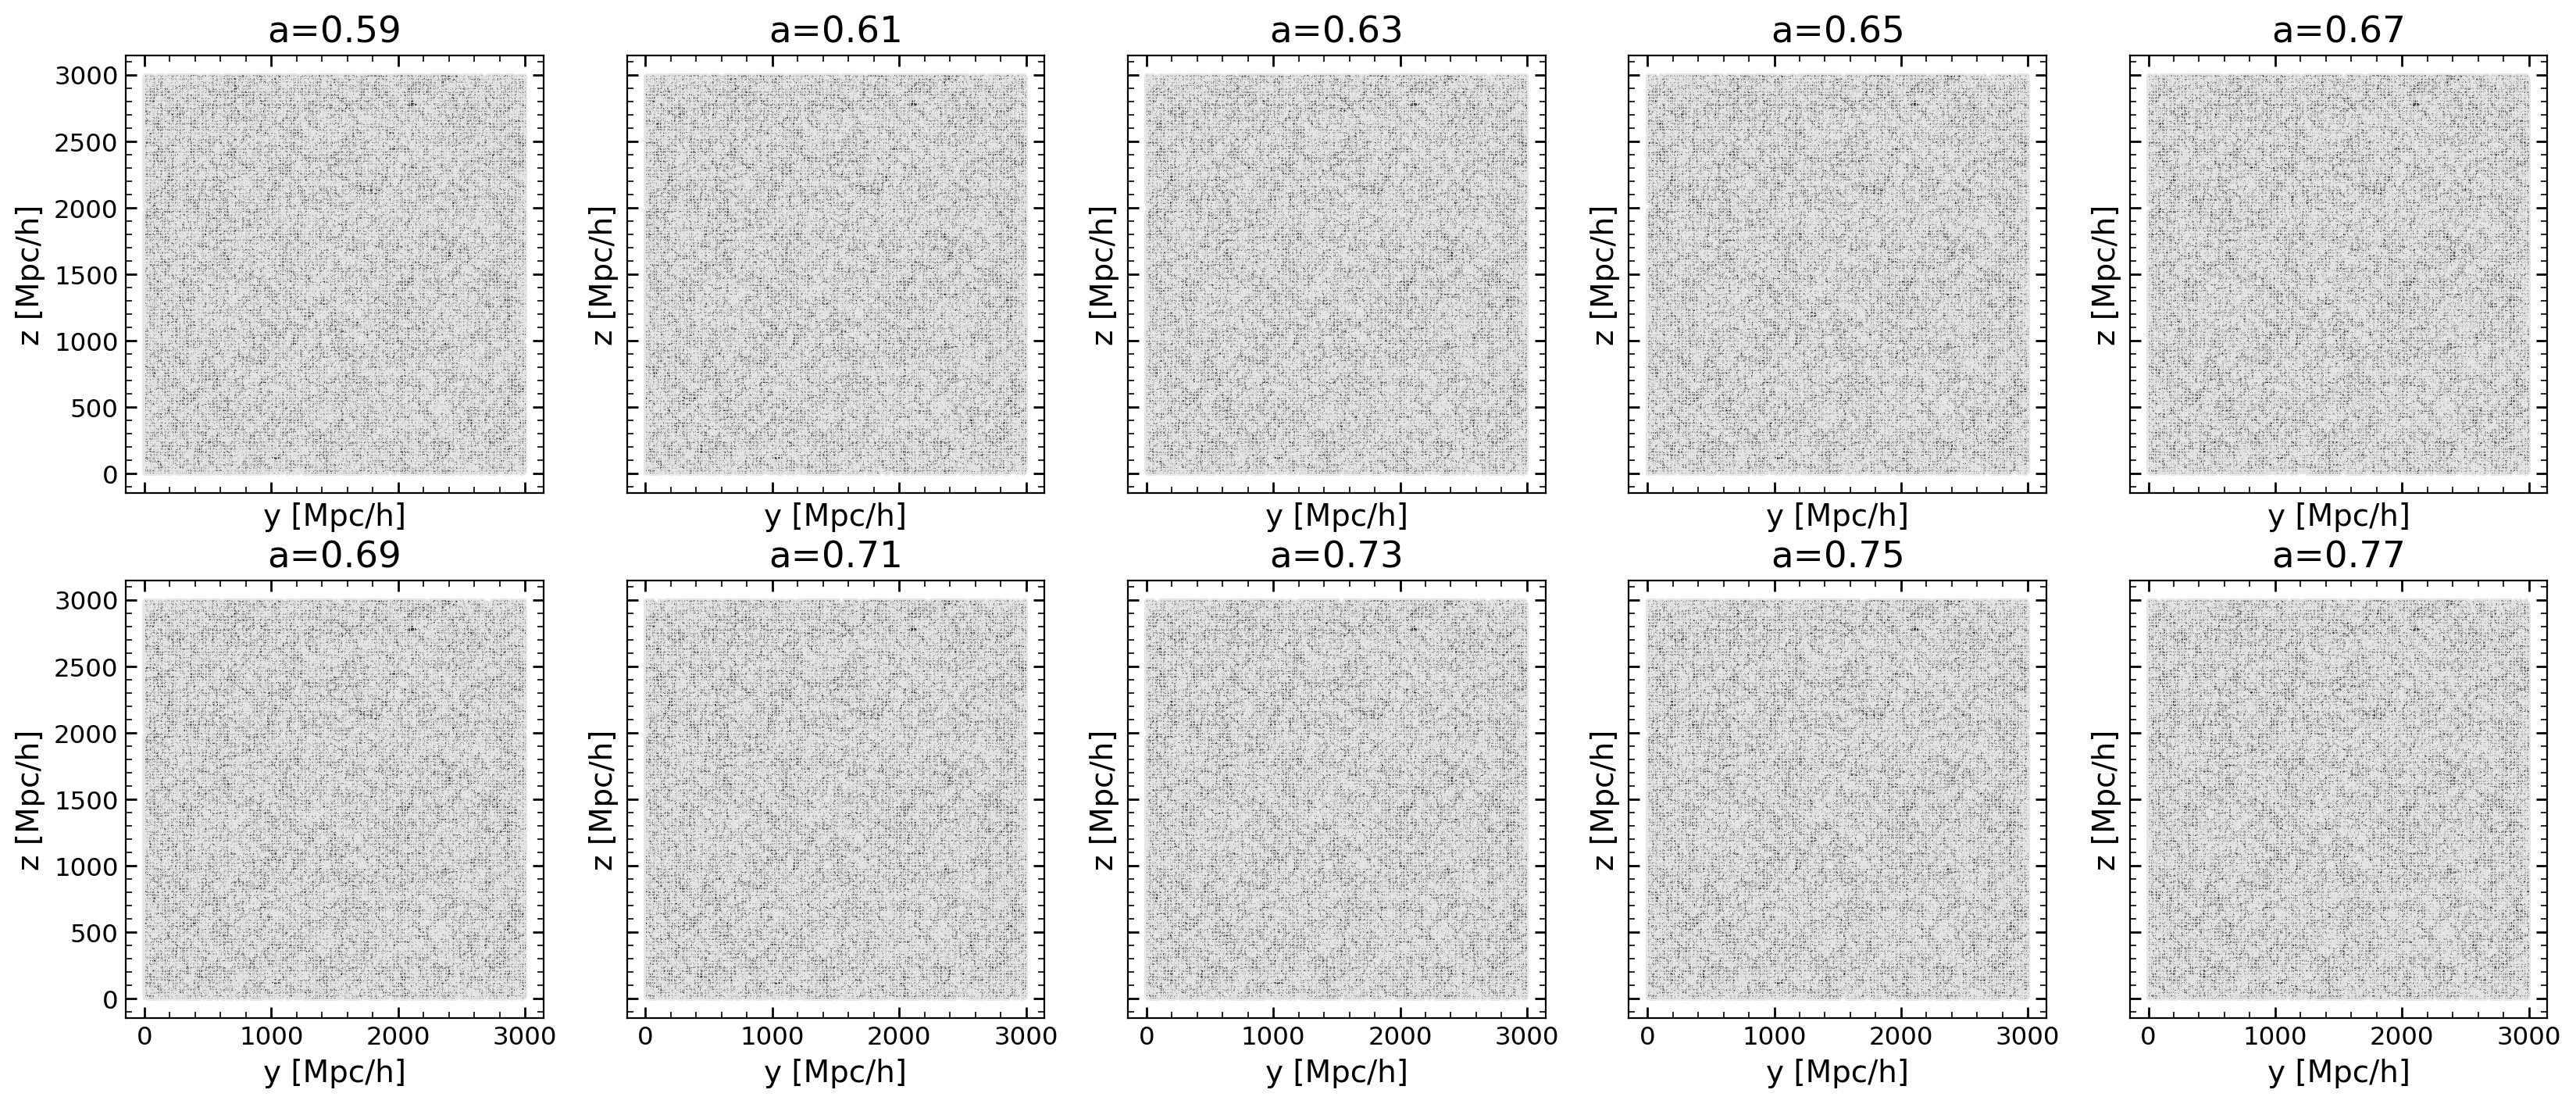

In [5]:
# Plot halos
def plot_slice(xyz, x0, dx, ax, **kwargs):
    mask = (xyz[:, 0] > x0) & (xyz[:, 0] < x0 + dx)
    ax.plot(xyz[mask, 1], xyz[mask, 2], **kwargs)


f, axs = plt.subplots(2, Nsnap//2, figsize=(20, 8), sharex=True, sharey=True)
axs = axs.flatten()
for i, ax in enumerate(axs):
    plot_slice(hposs[i], 1500, 50, ax, c='k', marker=',', alpha=0.1)
    ax.set(
        xlabel='y [Mpc/h]',
        ylabel='z [Mpc/h]',
        title=f'a={asave[i]:.2f}'
    )

In [6]:
# apply HOD (cmass.bias.apply_hod)
from cmass.bias.apply_hod import populate_hod

model = 'zheng07'
theta = dict(
    logMmin=13.5,
    sigma_logM=0.38,
    logM0=13.27,
    logM1=14.08,
    alpha=0.76,
)
seed = 0

gposs, gvels, gmetas = [], [], []
for i, a in enumerate(asave):
    redshift = (1/a) - 1
    print(f'Applying HOD at a={a:.2f} (z={redshift:.2f})')

    # setup HOD
    hod = populate_hod(
        hposs[i], hvels[i], hmasses[i],
        cosmo, L, redshift,
        model, theta,
        seed=seed,
        hmeta=hmetas[i],  # this stores halo concentration, can also store halo obs redshift # noqa
        mdef='200c'
    )

    # Organize outputs
    gpos = np.array(
        [hod['x'], hod['y'], hod['z']]).T  # comoving positions [Mpc/h]
    gvel = np.array(
        [hod['vx'], hod['vy'], hod['vz']]).T  # physical velocities [km/s]
    gmeta = {'gal_type': hod['gal_type'], 'hostid': hod['halo_id']}

    gposs.append(gpos), gvels.append(gvel), gmetas.append(gmeta)

[22:35:37-INFO] Running populate_hod...
[22:35:37-INFO] Using saved halo concentration...


Applying HOD at a=0.59 (z=0.71)


[22:36:10-INFO] Finished populate_hod... (0m33s)
[22:36:10-INFO] Running populate_hod...
[22:36:10-INFO] Using saved halo concentration...


Applying HOD at a=0.61 (z=0.65)


[22:36:29-INFO] Finished populate_hod... (0m18s)
[22:36:29-INFO] Running populate_hod...
[22:36:29-INFO] Using saved halo concentration...


Applying HOD at a=0.63 (z=0.60)


[22:36:48-INFO] Finished populate_hod... (0m19s)
[22:36:48-INFO] Running populate_hod...
[22:36:48-INFO] Using saved halo concentration...


Applying HOD at a=0.65 (z=0.55)


[22:37:12-INFO] Finished populate_hod... (0m23s)
[22:37:12-INFO] Running populate_hod...
[22:37:12-INFO] Using saved halo concentration...


Applying HOD at a=0.67 (z=0.50)


[22:37:38-INFO] Finished populate_hod... (0m26s)
[22:37:38-INFO] Running populate_hod...
[22:37:38-INFO] Using saved halo concentration...


Applying HOD at a=0.69 (z=0.46)


[22:38:07-INFO] Finished populate_hod... (0m28s)
[22:38:07-INFO] Running populate_hod...
[22:38:07-INFO] Using saved halo concentration...


Applying HOD at a=0.71 (z=0.41)


[22:38:30-INFO] Finished populate_hod... (0m23s)
[22:38:30-INFO] Running populate_hod...
[22:38:30-INFO] Using saved halo concentration...


Applying HOD at a=0.73 (z=0.38)


[22:38:57-INFO] Finished populate_hod... (0m27s)
[22:38:57-INFO] Running populate_hod...
[22:38:57-INFO] Using saved halo concentration...


Applying HOD at a=0.75 (z=0.34)


[22:39:28-INFO] Finished populate_hod... (0m30s)
[22:39:28-INFO] Running populate_hod...
[22:39:28-INFO] Using saved halo concentration...


Applying HOD at a=0.77 (z=0.30)


[22:39:55-INFO] Finished populate_hod... (0m27s)


In [40]:
# construct lightcone (cmass.survey.lightcone)
# make sure you've built cmass.lightcone first and loaded gsl

from cmass.lightcone import lc

# load mask
boss_dir = '/anvil/scratch/x-mho1/cmass-ili/obs'
maskobs = lc.Mask(boss_dir=boss_dir, veto=True)

# setup lightcone constructor
nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z'  # for real BOSS (n(z))
# nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z-fake'  # for infinite n(z), no subsample # noqa
snap_times = sorted(asave)[::-1]
lightcone = lc.Lightcone(
    boss_dir=nz_dir,
    mask=maskobs,
    Omega_m=cosmo.Om0,
    zmin=0.4,
    zmax=0.7,
    snap_times=snap_times,
    verbose=True,
    stitch_before_RSD=True,
    augment=0,
    seed=0
)

process_times
interpolate_chi_z
read_boss_nz


In [41]:
from cmass.survey.lightcone import split_galsnap_galidx

for i, a in enumerate(snap_times):
    # Load galaxies
    gpos, gvel = gposs[i], gvels[i]
    hostid = gmetas[i]['hostid']

    # Load halos
    hvel = hvels[i]

    # Get host velocites
    hostvel = hvel[hostid]
    lightcone.add_snap(i, gpos, gvel, hostvel)

# stitch lightcone
ra, dec, z, galid = lightcone.finalize()

# Split galid into galsnap and galidx
galsnap, galidx = split_galsnap_galidx(galid)
grdz = np.array([ra, dec, z]).T

	remap_snapshot
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose_galaxies
Done with snap index 2
	remap_snapshot
	choose_galaxies
Done with snap index 3
	remap_snapshot
	choose_galaxies
Done with snap index 4
	remap_snapshot
	choose_galaxies
Done with snap index 5
	remap_snapshot
	choose_galaxies
Done with snap index 6
	remap_snapshot
	choose_galaxies
Done with snap index 7
	remap_snapshot
	choose_galaxies
Done with snap index 8
	remap_snapshot
	choose_galaxies
Done with snap index 9
downsample
keep_fraction:
0.29 0.35 0.42 0.53 0.71 0.89 1.06 1.46 1.78 2.15 2.20 2.43 2.83 2.97 3.04 2.98 2.91 2.86 2.91 2.86 2.75 2.51 2.57 2.58 2.63 2.60 2.42 2.32 2.28 2.13 1.86 1.70 1.75 1.66 1.57 1.45 1.43 1.30 1.24 1.08 0.98 0.89 0.83 0.75 0.67 0.64 0.60 0.53 0.47 0.41 0.38 0.36 0.33 
fibcoll
downsample
keep_fraction:
0.86 0.90 0.88 0.90 0.92 0.95 1.03 1.44 1.74 2.08 2.16 2.38 2.76 2.88 2.98 2.92 2.83 2.83 2.88 2.83 2.73 2.46 2.56

[WARNING] at z=0.4368, do not have enough galaxies, keep_fraction=1.0302
[WARNING] at z=0.4425, do not have enough galaxies, keep_fraction=1.4363
[WARNING] at z=0.4481, do not have enough galaxies, keep_fraction=1.7442
[WARNING] at z=0.4538, do not have enough galaxies, keep_fraction=2.0828
[WARNING] at z=0.4594, do not have enough galaxies, keep_fraction=2.1618
[WARNING] at z=0.4651, do not have enough galaxies, keep_fraction=2.3750
[WARNING] at z=0.4708, do not have enough galaxies, keep_fraction=2.7612
[WARNING] at z=0.4764, do not have enough galaxies, keep_fraction=2.8792
[WARNING] at z=0.4821, do not have enough galaxies, keep_fraction=2.9786
[WARNING] at z=0.4877, do not have enough galaxies, keep_fraction=2.9228
[WARNING] at z=0.4934, do not have enough galaxies, keep_fraction=2.8349
[WARNING] at z=0.4991, do not have enough galaxies, keep_fraction=2.8340
[WARNING] at z=0.5047, do not have enough galaxies, keep_fraction=2.8804
[WARNING] at z=0.5104, do not have enough galaxies,

[Text(0.5, 0, 'z'), Text(0, 0.5, 'N')]

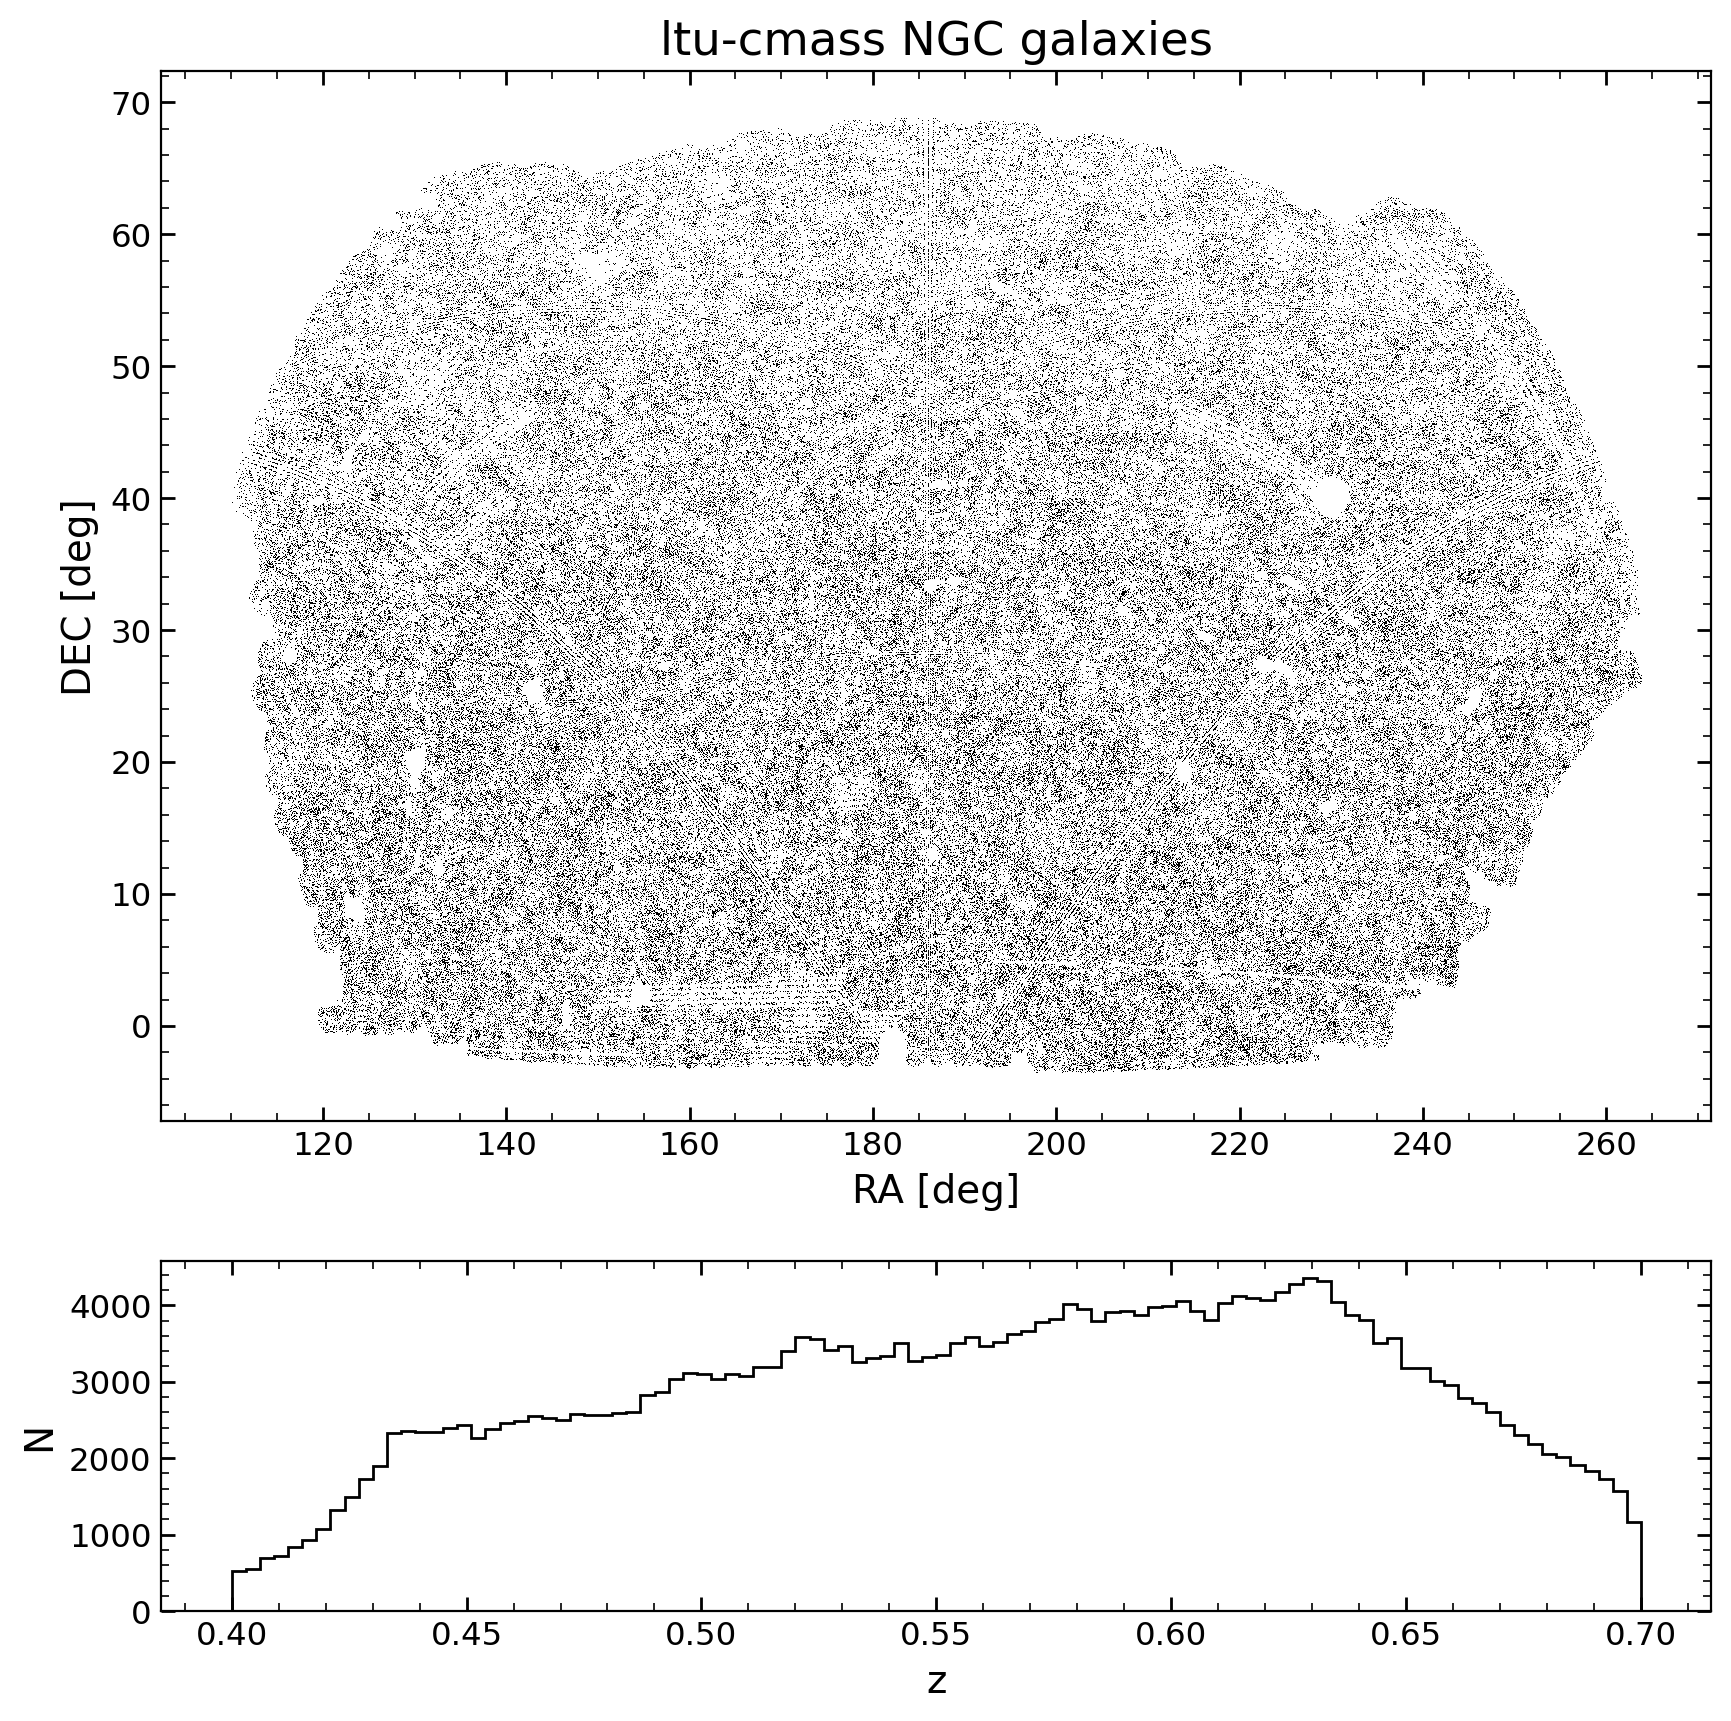

In [42]:
f, axs = plt.subplots(2, 1, figsize=(10, 10),
                      gridspec_kw=dict(height_ratios=[3, 1]))

ax = axs[0]
ax.plot(grdz[:, 0], grdz[:, 1], 'k,', alpha=1)
ax.set(
    xlabel='RA [deg]',
    ylabel='DEC [deg]',
    title='ltu-cmass NGC galaxies'
)

ax = axs[1]
ax.hist(grdz[:, 2], bins=100, histtype='step', color='k')
ax.set(
    xlabel='z',
    ylabel='N'
)

(0.35, 0.75)

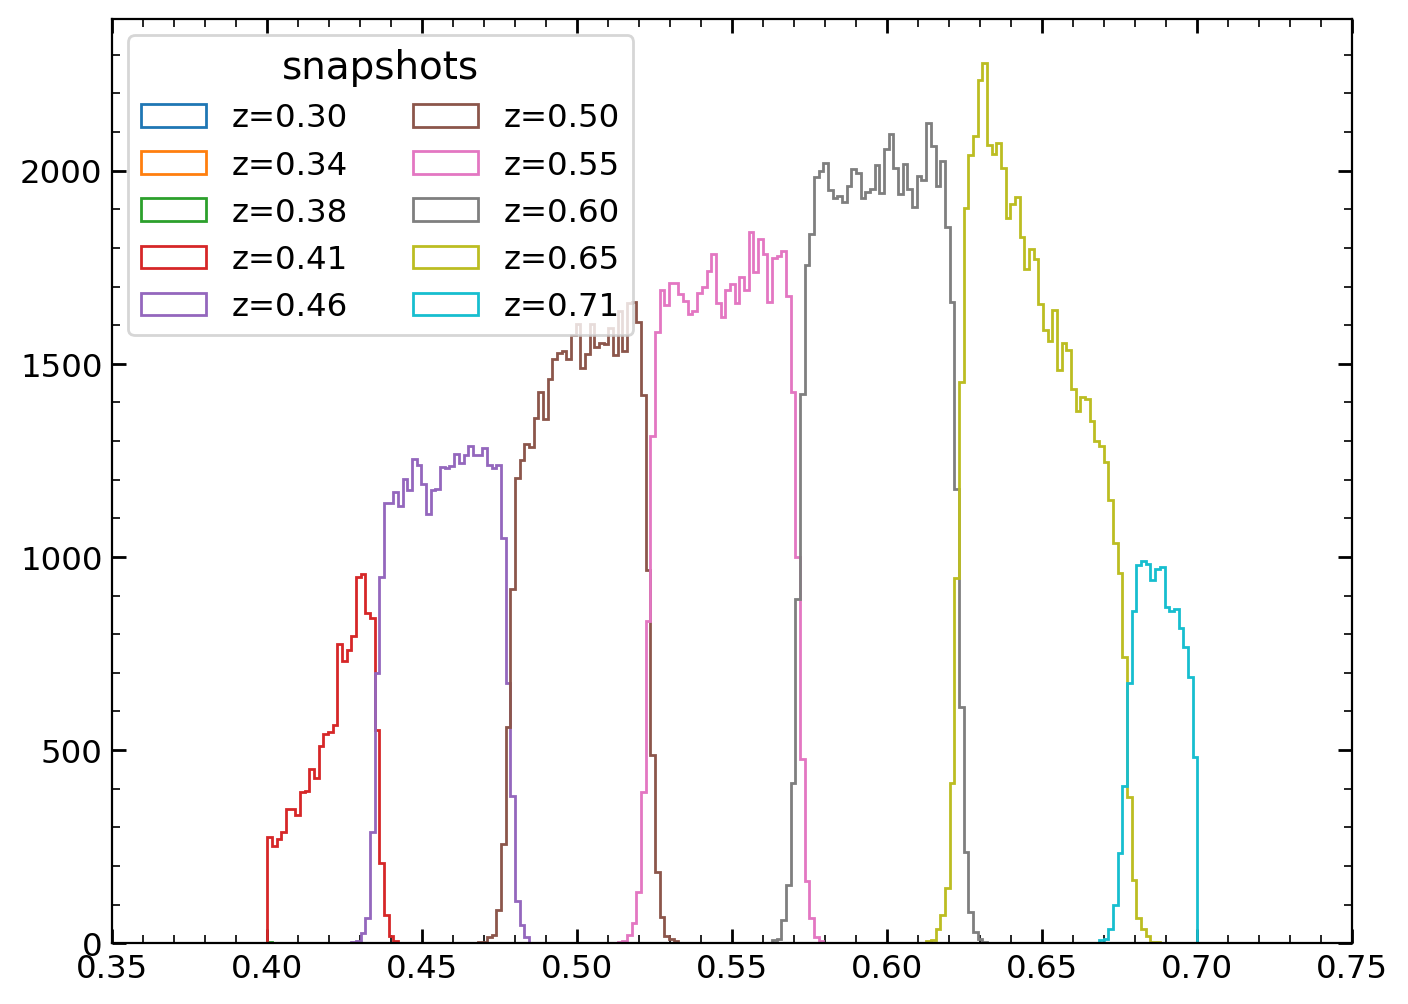

In [44]:
# plot n(z) based on base snapshot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
be = np.linspace(0.4, 0.7, 200)
for i, a in enumerate(snap_times):
    z = (1/a) - 1
    ax.hist(grdz[galsnap == i, 2], bins=be, histtype='step',
            color=f'C{i}', label=f'z={z:.2f}')
ax.legend(ncol=2, title='snapshots')
ax.set_xlim(0.35, 0.75)

In [ ]:
# Get the halos' positions in redshift space
# this is a bit of a hack, giving each halo one galaxy
# we're keeping all halos, so we know where they go

# setup lightcone constructor
# nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z'  # for real BOSS (n(z))
nz_dir = '/anvil/scratch/x-mho1/cmass-ili/obs/n-z-fake'  # for infinite n(z), no subsample # noqa
snap_times = sorted(asave)[::-1]
lightcone = lc.Lightcone(
    boss_dir=nz_dir,
    mask=maskobs,
    Omega_m=cosmo.Om0,
    zmin=0.4,
    zmax=0.7,
    snap_times=snap_times,
    verbose=True,
    stitch_before_RSD=True,
    augment=0,
    seed=0
)

for i, a in enumerate(snap_times):
    # Load galaxies
    gpos, gvel = hposs[i], hvels[i]  # inherit the halo positions and velocities
    hostid = np.arange(len(hposs[i]))

    # Get host velocites
    hostvel = gvel
    lightcone.add_snap(i, gpos, gvel, hostvel)

# stitch lightcone
ra, dec, z, galid = lightcone.finalize()

# Split galid into galsnap and galidx
galsnap, galidx = split_galsnap_galidx(galid)
grdz = np.array([ra, dec, z]).T

process_times
interpolate_chi_z
read_boss_nz
	remap_snapshot
	choose_galaxies
Done with snap index 0
	remap_snapshot
	choose_galaxies
Done with snap index 1
	remap_snapshot
	choose_galaxies
Done with snap index 2
	remap_snapshot
	choose_galaxies
Done with snap index 3
	remap_snapshot
	choose_galaxies
Done with snap index 4
	remap_snapshot
	choose_galaxies
Done with snap index 5
	remap_snapshot
	choose_galaxies
Done with snap index 6
	remap_snapshot
	choose_galaxies
Done with snap index 7
	remap_snapshot
	choose_galaxies
Done with snap index 8
	remap_snapshot
	choose_galaxies
Done with snap index 9
downsample
keep_fraction:
65.67 64.06 60.97 59.81 57.52 56.78 53.84 56.05 55.65 54.27 53.66 51.04 50.70 50.99 51.14 50.66 48.23 45.62 43.45 43.93 43.69 41.90 39.78 40.57 42.18 42.20 40.97 41.52 41.04 38.81 39.23 37.95 37.40 37.00 37.03 35.79 36.41 35.67 36.31 35.46 35.16 34.65 33.90 32.88 32.57 31.96 31.84 31.51 31.84 31.07 30.80 30.33 30.35 30.12 30.55 35.65 
fibcoll
downsample
keep_fraction

[WARNING] at z=0.4027, do not have enough galaxies, keep_fraction=65.8935
[WARNING] at z=0.4080, do not have enough galaxies, keep_fraction=65.5265
[WARNING] at z=0.4134, do not have enough galaxies, keep_fraction=62.6606
[WARNING] at z=0.4188, do not have enough galaxies, keep_fraction=61.1471
[WARNING] at z=0.4241, do not have enough galaxies, keep_fraction=58.7786
[WARNING] at z=0.4295, do not have enough galaxies, keep_fraction=58.1903
[WARNING] at z=0.4348, do not have enough galaxies, keep_fraction=55.0782
[WARNING] at z=0.4402, do not have enough galaxies, keep_fraction=57.5341
[WARNING] at z=0.4455, do not have enough galaxies, keep_fraction=57.4119
[WARNING] at z=0.4509, do not have enough galaxies, keep_fraction=56.0758
[WARNING] at z=0.4563, do not have enough galaxies, keep_fraction=55.0267
[WARNING] at z=0.4616, do not have enough galaxies, keep_fraction=52.2603
[WARNING] at z=0.4670, do not have enough galaxies, keep_fraction=51.9481
[WARNING] at z=0.4723, do not have eno

In [36]:
# galidx contains the galaxy index in the galsnap snapshot

# assign sky positions and redshifts to each halo
hrdzs = []
for i, a in enumerate(snap_times):
    mask = galsnap == i

    hrdz = np.nan * np.ones(hposs[i].shape)
    if np.sum(mask) > 0:
        ginds = galidx[mask]
        hrdz[ginds] = grdz[mask]
    hrdzs.append(hrdz)

(0.35, 0.75)

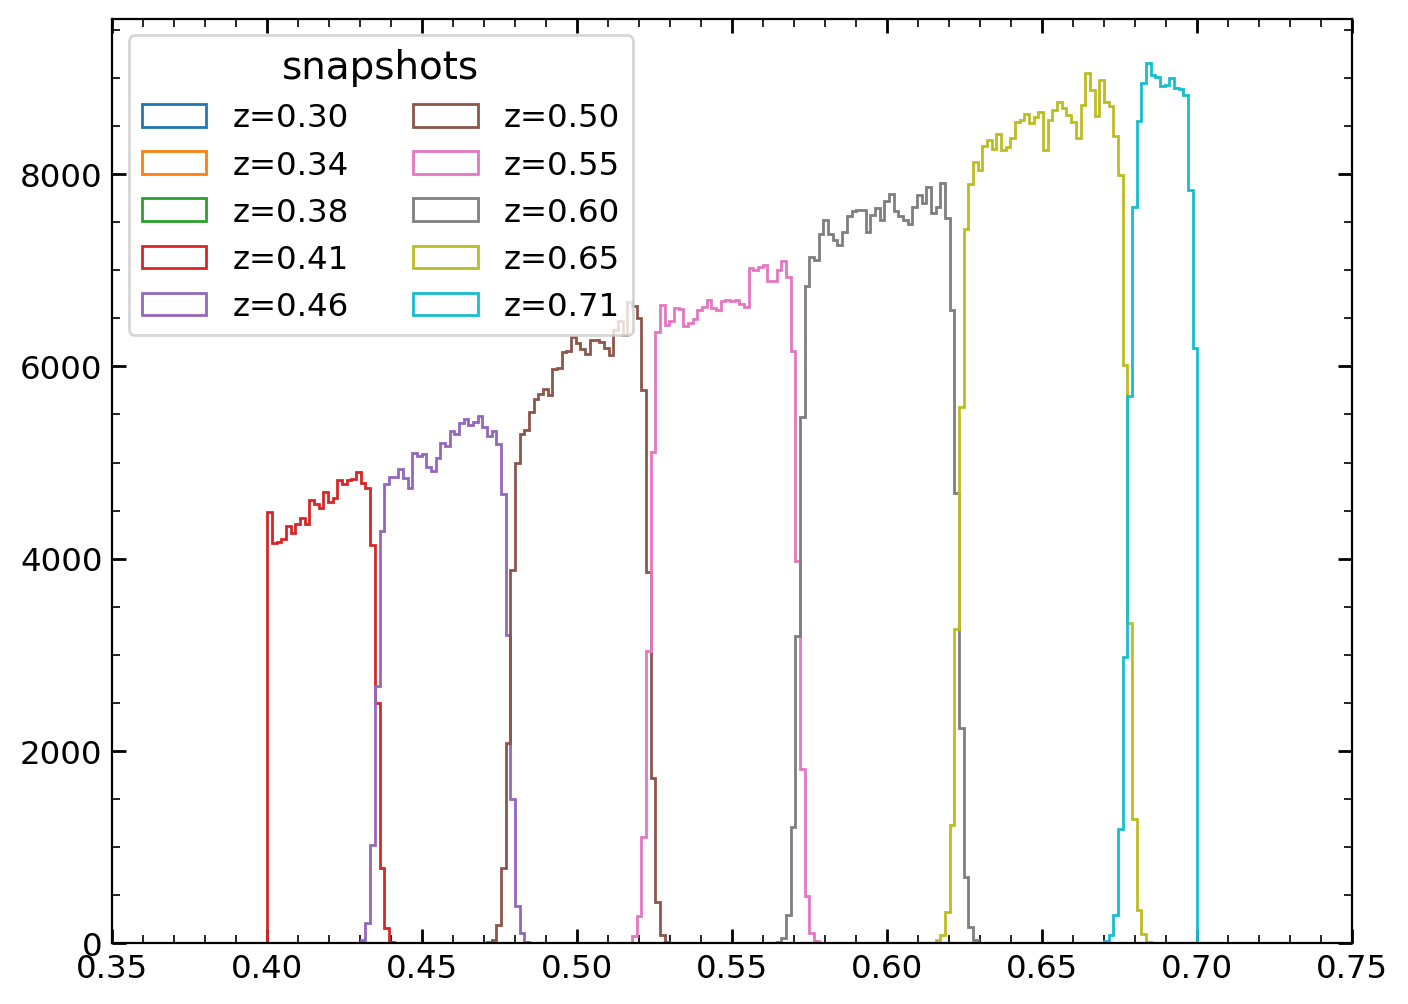

In [39]:
# plot n(z) based on base snapshot
f, ax = plt.subplots(1, 1, figsize=(8, 6))
be = np.linspace(0.4, 0.7, 200)
for i, a in enumerate(snap_times):
    z = (1/a) - 1
    hrdz = hrdzs[i]
    ax.hist(hrdz[~np.isnan(hrdz).any(axis=1)][:, 2],
            bins=be, histtype='step',
            color=f'C{i}', label=f'z={z:.2f}')
ax.legend(ncol=2, title='snapshots')
ax.set_xlim(0.35, 0.75)